In [90]:
from datetime import date
from glob import glob
import json
import math
import os
import sys
import time

import gspread
import numpy as np
import pandas as pd
import pingouin as pg
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy import integrate, interpolate, stats

C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_events_wdict
from PCIst.PCIst.pci_st import calc_PCIst, dimensionality_reduction

In [4]:
%matplotlib widget

#### Load excel sheet with metadata for experiments

In [5]:
_gc = gspread.service_account() # need a key file to access the account
## Load Templeton log ##
_sh = _gc.open('Templeton-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
Temp_metadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe
## Load Zap&zip log ##
_sh = _gc.open('Zap_Zip-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
ZZ_metadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

In [6]:
plotdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\brain_states_analyses\EP metrics'

In [7]:
inj_states = ['psilocybin', 'ketanserin', 'saline']

### Functions

In [8]:
def get_good_bad_chs(bad_ch_str, ch_list):
    if bad_ch_str == 'all':
        bad_chs = ch_list
        good_chs = []
    else:
        badchstr = bad_ch_str.replace(' ','')
        bad_chs = []
        for char in badchstr.split(','):
            if char.isdecimal():
                bad_chs.append(int(char))
        good_chs = np.array([x for x in ch_list if x not in bad_chs])
    return good_chs, bad_chs

### Load subjects .csv

In [9]:
multisub_file = r"C:\Users\lesliec\OneDrive - Allen Institute\data\psilocybin_saline_subjects_2024_07.csv"
subject_df = pd.read_csv(multisub_file, converters={'mouse': str}).astype({'analyze_EEG': bool, 'analyze_NPX': bool})

In [10]:
subject_df.head()

,exp_type,mouse,experiment,sweep_states,bad_chs,analyze_EEG,analyze_NPX,CCF_res,notes
0,urethane,582386,urethane_2021-07-15_11-36-58,urethane,"0,2,3",True,True,10,NaN
1,urethane,638703,urethane_estim_2022-10-14_12-25-20,urethane,"0,3,4,6,7,11,13",True,True,25,NaN
2,urethane,654181,urethane_vis_2022-11-23_08-30-16,urethane,"7,8,11,13",True,True,25,NaN
3,saline,654182,estim_vis_2022-12-01_10-33-50,"awake,saline","3,6,14,22,23",True,True,25,NaN
4,urethane,654182,urethane_vis_2022-12-02_11-02-25,urethane,"3,6,14,22,23",True,True,25,NaN


### Multi-subject loop

#### Get EEG traces for all states/estim

In [12]:
StimType = 'biphasic'

inj_window = 90 * 60 # min to include as "psilocybin" -> seconds

trial_threshold = 30 # must have more than this number of trials to be included in analysis
trial_max = 100 # limit some states that have many trials

comps = ['saline', 'psilocybin']
behaviors = {'rest': True, 'run': False}

PCI_params = {
    'baseline_window': (-0.8, -0.002), # s before stim for baseline, my default: (-0.5, -0.001)
    'response_window': (0.002, 0.8), # s after stim for response, my default: (0.001, 0.5)
    'k': 1.2,
    'min_snr': 1.1, # my default: 1.1, used 1.6 for eLife paper?
    'max_var': 99,
    'embed': False,
    'n_steps': 100,
}
zlim = 3
comp_dict = {'first': [0.002, 0.025], 'early': [0.003, 0.05], 'late': [0.15, 0.25]}

In [17]:
subexp.ephys_params['EEG']['sample_rate']

2500

In [19]:
all_sub_metrics = []
for dfind, subrow in subject_df.iterrows():
    if subrow.exp_type not in comps:
        continue
    print('{}: {}'.format(subrow.mouse, subrow.exp_type))
    if not subrow.analyze_EEG:
        print(' Not analyzing this experiment: "analyze"=False.')
        continue
    if subrow.bad_chs == 'all':
        print(' Not analyzing this experiment: bad EEG.')
        continue
        
    data_loc = os.path.join('F:\psi_exp', 'mouse' + subrow.mouse, subrow.experiment, 'experiment1', 'recording1')
    subexp = EEGexp(data_loc, preprocess=False, make_stim_csv=False)

    ## Grab exp metadata from Templeton-log_exp ##
    if np.any([True if subrow.mouse in x else False for x in np.unique(Temp_metadata['mouse_name'].values)]):
        exp_meta = Temp_metadata[(
            (Temp_metadata['mouse_name'].str.contains(subrow.mouse)) & (Temp_metadata['exp_name'].str.contains(subrow.experiment))
        )].squeeze()
    elif np.any([True if subrow.mouse in x else False for x in np.unique(ZZ_metadata['mouse_name'].values)]):
        exp_meta = ZZ_metadata[(
            (ZZ_metadata['mouse_name'].str.contains(subrow.mouse)) & (ZZ_metadata['exp_name'].str.contains(subrow.experiment))
        )].squeeze()
    else:
        print('Cannot find {}: {} in the experiment log excel sheets.'.format(subrow.mouse, subrow.experiment))

    ## Get injection times ##
    if subrow.exp_type in inj_states:
        inj_times = [float(exp_meta['First injection time (s)']), float(exp_meta['Second injection time (s)'])]
    else:
        print('  This {} experiment has no injection times.'.format(subrow.exp_type))
        inj_times = None

    ## Load stim log and apply sweep labels ##
    stim_log = pd.read_csv(subexp.stimulus_log_file).astype({'parameter': str})
    ### Get state label for each sweep ###
    all_sweeps = np.unique(stim_log['sweep'].values)
    sweep_state_list = []
    for char in subrow.sweep_states.split(','):
        sweep_state_list.append(char)
    if len(sweep_state_list) == 1:
        sweep_state_list = sweep_state_list * len(all_sweeps)
    stim_log['state'] = stim_log.apply(lambda x: sweep_state_list[x.sweep], axis=1)
    ### Get list of states and the middle current ###
    states = np.unique(stim_log['state'].values)
    currents = np.unique(stim_log[stim_log['stim_type'] == 'biphasic']['parameter'].values).astype(int)
    if len(currents) > 1:
        estim_current = {x: str(y) for x, y in zip(['low', 'mid', 'high'], currents)}
    else:
        estim_current = {'mid': str(currents[0])}

    ## Load EEG traces ##
    all_EEG_traces = np.load(os.path.join(subexp.data_folder, 'evoked_data', 'event_EEGtraces.npy'))
    EEG_event_timestamps = np.load(os.path.join(subexp.data_folder, 'evoked_data', 'event_EEGtraces_times.npy'))
    eeg_chs = np.arange(0, all_EEG_traces.shape[1])
    GOOD_CHS, bad_chs = get_good_bad_chs(subrow.bad_chs, eeg_chs)

    ## Get event traces ##
    estimlog = stim_log[stim_log['stim_type'] == StimType]
    for clevel, parami in estim_current.items():
        for behi, restTF in behaviors.items():
            for statei in states:
                eventdf = get_events_wdict(
                    estimlog, {'state': statei, 'parameter': parami, 'good': True, 'resting_trial': restTF}, out='df')
                ## Add injection times ##
                if statei in inj_states:
                    eventdf['onset_from_inj'] = eventdf['onset'] - inj_times[1]
                    event_inds = eventdf[eventdf['onset_from_inj'] < inj_window].index.values
                else:
                    event_inds = eventdf.index.values
                if len(event_inds) < trial_threshold:
                    continue
                elif len(event_inds) > trial_max:
                    event_inds = np.random.choice(event_inds, size=trial_max, replace=False)
                event_traces = all_EEG_traces[:, :, event_inds]
                ## Apply common average reference ##
                event_traces = event_traces - np.mean(event_traces[:, GOOD_CHS, :], axis=1)[:,None,:]
                #all_info[mousei][subrow.exp_type]['EEG_traces'][statei][clevel]# = [EEG_event_timestamps, event_traces]


                #### CALC METRICS ####
                num_trials = event_traces.shape[2]
                state_avg = np.mean(event_traces, axis=2)

                ## Calculate global field power duration ##
                gfpow = np.std(state_avg[:, GOOD_CHS], axis=1)
                blmean = np.mean(gfpow[EEG_event_timestamps < 0])
                blstd = np.std(gfpow[EEG_event_timestamps < 0])
                zgfpow = (gfpow - blmean) / blstd
                response_duration = np.sum(zgfpow[EEG_event_timestamps > 0] > zlim) / subexp.ephys_params['EEG']['sample_rate']

                ## Area under global field power curve ##
                zerp = np.where((zgfpow[EEG_event_timestamps > 0] - zlim) >= 0, (zgfpow[EEG_event_timestamps > 0] - zlim), 0.)
                auc = integrate.simps(zerp, EEG_event_timestamps[EEG_event_timestamps > 0], axis=0, even='last')

                ## Calulate PCIst ##
                PCIval = calc_PCIst(state_avg[:, GOOD_CHS].T, EEG_event_timestamps, **PCI_params)
                
                ## Rectified amplitude ##
                rect_mean = np.mean(np.abs(state_avg[:, GOOD_CHS]), axis=1)
                amptemp = []
                for wini, windowi in comp_dict.items():
                    testinds = np.nonzero((EEG_event_timestamps >= windowi[0]) & (EEG_event_timestamps <= windowi[1]))[0]
                    amptemp.append(np.mean(rect_mean[testinds]))

                all_sub_metrics.append([
                    subrow.mouse, subrow.exp_type, len(GOOD_CHS), statei, clevel, behi, num_trials, amptemp[0], response_duration, auc, PCIval,
                    amptemp[1], amptemp[2]
                ])

    print('')
EEG_metrics = pd.DataFrame(
    all_sub_metrics,
    columns=['mouse', 'experiment', 'num_good_chs', 'state', 'stim_current', 'behavior', 'num_trials', 'first_peak_amp',
             'response_duration', 'response_magnitude', 'PCIst', 'early_amp', 'late_amp'
            ]
)

654182: saline
Experiment type: electrical and sensory stimulation

631037: saline
Experiment type: electrical stimulation

655955: saline
Experiment type: electrical stimulation

655956: saline
Experiment type: electrical stimulation

666193: saline
 Not analyzing this experiment: "analyze"=False.
666193: psilocybin
 Not analyzing this experiment: "analyze"=False.
666194: saline
 Not analyzing this experiment: "analyze"=False.
666194: psilocybin
 Not analyzing this experiment: "analyze"=False.
666196: saline
 Not analyzing this experiment: "analyze"=False.
666196: psilocybin
 Not analyzing this experiment: "analyze"=False.
669118: saline
Experiment type: electrical stimulation

669118: psilocybin
Experiment type: electrical stimulation

669117: saline
Experiment type: electrical stimulation

669117: psilocybin
Experiment type: electrical stimulation

673449: psilocybin
Experiment type: electrical stimulation

673449: psilocybin
 Not analyzing this experiment: "analyze"=False.
673449: 

In [20]:
EEG_metrics.head()

,mouse,experiment,num_good_chs,state,stim_current,behavior,num_trials,first_peak_amp,response_duration,response_magnitude,PCIst,early_amp,late_amp
0,654182,saline,25,awake,low,rest,94,44.753519,0.5480,4.904822,44.181153,25.699951,13.025641
1,654182,saline,25,saline,low,rest,100,36.098254,0.3496,1.865325,35.319799,20.471536,13.940689
2,654182,saline,25,awake,mid,rest,90,93.339172,0.4696,7.974522,62.260551,55.084249,23.480233
3,654182,saline,25,saline,mid,rest,88,81.883977,0.4400,3.499893,30.261454,48.125041,24.251950
4,654182,saline,25,awake,mid,run,30,87.824585,0.2820,0.790639,44.302857,50.245585,17.298871


In [22]:
all_mice = np.unique(EEG_metrics['mouse'].values)
print(all_mice)

['631037' '654182' '655955' '655956' '669117' '669118' '673449' '676726'
 '676727' '689240' '689242' '703064' '703065' '730911' '735049']


In [117]:
plot_metric = 'first_peak_amp' #'PCIst', 'late_amp'
pre_post_metrics = {}
for behi in behaviors.keys():
    pre_post_metrics[behi] = {}
    for inji in comps:
        pre_post_metrics[behi][inji] = {}
        for clevel in ['low', 'mid', 'high']:
            temp_metrics = []
            for mousei in all_mice:
                mEEG = EEG_metrics[
                    (EEG_metrics['mouse'] == mousei) & (EEG_metrics['experiment'] == inji) &
                    (EEG_metrics['behavior'] == behi) & (EEG_metrics['stim_current'] == clevel)
                ]
                # print('{} - {} - {} - {}: {:d} states'.format(mousei, inji, behi, clevel, len(mEEG)))
                if len(mEEG) < 2:
                    continue
                stats = []
                for statei in ['awake', inji]:
                    stats.append(mEEG[mEEG['state'] == statei][plot_metric].values[0])
                if len(stats) == 2:
                    temp_metrics.append(stats)
            if len(temp_metrics) > 0:
                pre_post_metrics[behi][inji][clevel] = np.array(temp_metrics)

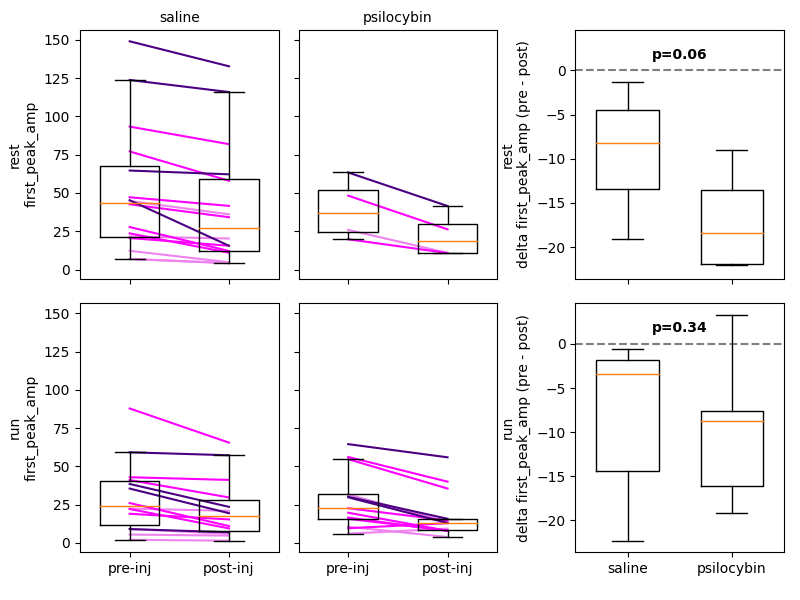

In [118]:
ccols = {'low': 'violet', 'mid': 'magenta', 'high': 'indigo'}
# ccols = {'low': 'lightsalmon', 'mid': 'darkorange', 'high': 'green'}

fig = plt.figure(figsize=(8,6))
gs = fig.add_gridspec(ncols=2, nrows=1, left=0.1, right=0.98, top=0.95, bottom=0.08, wspace=0.25, width_ratios=[2,1])
axs = gs[0].subgridspec(nrows=2, ncols=2, wspace=0.1, hspace=0.1).subplots(sharex=True, sharey=True)
diffaxs = gs[1].subgridspec(nrows=2, ncols=1, hspace=0.1).subplots(sharex=True, sharey=True)

for rowi, behi in enumerate(behaviors.keys()):
    diffaxs[rowi].axhline(0, color='k', linestyle='dashed', alpha=0.5)
    states_comp = []
    for coli, inji in enumerate(comps):
        temp_all = []
        for clevel, cc in ccols.items():
            metvals = pre_post_metrics[behi][inji][clevel]
            temp_all.append(metvals)
            # axs[rowi,coli].boxplot(metvals, positions=[0, 1], widths=[0.6, 0.6], showfliers=False);
            axs[rowi,coli].plot([0,1], metvals.T, color=cc, linewidth=1.5)
        axs[rowi,coli].boxplot(np.vstack(temp_all), positions=[0, 1], widths=[0.6, 0.6], showfliers=False)
        if rowi == 0:
            axs[rowi,coli].set_title(inji)
        if coli == 0:
            axs[rowi,coli].set_ylabel('{}\n{}'.format(behi, plot_metric))
        
        diffaxs[rowi].boxplot(np.diff(np.vstack(temp_all), axis=-1), positions=[coli], widths=[0.6], showfliers=False)
        diffaxs[rowi].set_ylabel('{}\ndelta {} (pre - post)'.format(behi, plot_metric)) #r'$\lambda$'
        states_comp.append(np.diff(np.vstack(temp_all), axis=-1).flatten())
    mwustats = pg.mwu(states_comp[0], states_comp[1])
    diffaxs[rowi].annotate(
        'p={:.2f}'.format(mwustats['p-val'].values[0]), xy=(0.5, 0.9), xycoords='axes fraction', ha='center', va='center', fontsize=10, fontweight='bold'
    )

axs[1,0].set_xticks([0,1])
axs[1,0].set_xticklabels(['pre-inj', 'post-inj']);

diffaxs[rowi].set_xticks([0,1])
diffaxs[rowi].set_xticklabels(['saline', 'psilocybin']);

## Save ##
figname = 'SalPsi_restrun_{}_{}.png'.format(plot_metric, date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotdir, figname), transparent=False, dpi=150)

In [107]:
plotdir

'C:\\Users\\lesliec\\OneDrive - Allen Institute\\data\\plots\\brain_states_analyses\\EP metrics'

## EP metrics

## Plot some metrics